In [11]:
import os
import sys
import math
import numpy as np
import pandas as pd
import scipy.stats as stat
from itertools import groupby
from datetime import  timedelta,datetime
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import time
R = 6.371*10**6

In [12]:
## 1. projection: distorted distance
def unique(list1):
  # intilize a null list
  unique_list = []
  # traverse for all elements
  for x in list1:
      # check if exists in unique_list or not
      if x not in unique_list:
          unique_list.append(x)
  return unique_list

def cartesian(lat,lon):
  lat = lat/180*math.pi
  lon = lon/180*math.pi
  z = R*np.sin(lat)
  u = R*np.cos(lat)
  x = u*np.cos(lon)
  y = u*np.sin(lon)
  return x,y,z

def great_circle_dist(lat1,lon1,lat2,lon2):
  lat1 = lat1/180*math.pi
  lon1 = lon1/180*math.pi
  lat2 = lat2/180*math.pi
  lon2 = lon2/180*math.pi
  temp = np.cos(lat1)*np.cos(lat2)*np.cos(lon1-lon2)+np.sin(lat1)*np.sin(lat2)
  if isinstance(temp,np.ndarray):
    temp[temp>1]=1
    temp[temp<-1]=-1
  else:
    if temp>1:
      temp=1
    if temp<-1:
      temp=-1
  theta = np.arccos(temp)
  d = theta*R
  return d

In [13]:
def LatLong2XY(Lat,Lon):
  latitude = Lat/180*math.pi
  longitude = Lon/180*math.pi
  lam_min=min(latitude)
  lam_max=max(latitude)
  phi_min=min(longitude)
  phi_max=max(longitude)
  R=6.371*10**6
  d1=(lam_max-lam_min)*R
  d2=(phi_max-phi_min)*R*math.sin(math.pi/2-lam_max)
  d3=(phi_max-phi_min)*R*math.sin(math.pi/2-lam_min)
  w1=(latitude-lam_min)/(lam_max-lam_min)
  w2=(longitude-phi_min)/(phi_max-phi_min)
  x=np.array(w1*(d3-d2)/2+w2*(d3*(1-w1)+d2*w1))
  y=np.array(w1*d1*math.sin(math.acos((d3-d2)/(2*d1))))
  return np.reshape(np.concatenate((x,y)),(len(x),2),order="F")

In [14]:
## helsinki and san francisco
lat0 = 37.61
lon0 = -122.40
lat1 = 60.32
lon1 = 24.95
d1_vec = []
d2_vec = []
d3_vec = []
for i in range(100):
  lat = np.array([lat0,lat0+(lat1-lat0)/100*(i+1),37.82])
  lon = np.array([lon0,lon0+(lon1-lon0)/100*(i+1),-122.48])
  d2 =  great_circle_dist(lat[0],lon[0],lat[-1],lon[-1])
  trapezoid = LatLong2XY(lat,lon)
  temp = np.sqrt((trapezoid[-1,0]-trapezoid[0,0])**2+(trapezoid[-1,1]-trapezoid[0,1])**2)
  d2_vec.append(temp)
  
  lat = np.array([lat0,lat0+(lat1-lat0)/100*(i+1),37.45])
  lon = np.array([lon0,lon0+(lon1-lon0)/100*(i+1),-122.16])
  d1 =  great_circle_dist(lat[0],lon[0],lat[-1],lon[-1])
  trapezoid = LatLong2XY(lat,lon)
  temp = np.sqrt((trapezoid[-1,0]-trapezoid[0,0])**2+(trapezoid[-1,1]-trapezoid[0,1])**2)
  d1_vec.append(temp)
  
  lat = np.array([lat0,lat0+(lat1-lat0)/100*(i+1),37.79])
  lon = np.array([lon0,lon0+(lon1-lon0)/100*(i+1),-122.36])
  d3 =  great_circle_dist(lat[0],lon[0],lat[-1],lon[-1])
  trapezoid = LatLong2XY(lat,lon)
  temp = np.sqrt((trapezoid[-1,0]-trapezoid[0,0])**2+(trapezoid[-1,1]-trapezoid[0,1])**2)
  d3_vec.append(temp)

In [15]:
d3_vec[-1]

23419.073731663393

In [5]:
plt.figure(figsize=(7,14))
plt.subplot(3, 1, 1)
plt.plot(np.arange(1,101),d2_vec,label = "projected distance")
plt.plot(np.arange(1,101),np.ones(100)*d2,"r--",label = "great circle distance")
plt.xlabel('Destination Latitude/Longitude')
plt.xticks(np.arange(101,step=20), ('37/-122', '41.6/-92.6', '46.2/-63.2', '50.8/-33.8', '55.4/-4.4','60/25'))
plt.ylabel('Distance between SFO and Golden Gate Bridge(m)')
plt.legend(loc='lower left', borderaxespad=0.3)

plt.subplot(3, 1, 2)
plt.plot(np.arange(1,101),d1_vec,label = "projected distance")
plt.plot(np.arange(1,101),np.ones(100)*d1,"r--",label = "great circle distance")
plt.xlabel('Destination Latitude/Longitude')
plt.xticks(np.arange(101,step=20), ('37/-122', '41.6/-92.6', '46.2/-63.2', '50.8/-33.8', '55.4/-4.4','60/25'))
plt.ylabel('Distance between SFO and Downtown Palo Alto(m)')
plt.legend(loc='lower left', borderaxespad=0.3)

plt.subplot(3, 1, 3)
plt.plot(np.arange(1,101),d3_vec,label = "projected distance")
plt.plot(np.arange(1,101),np.ones(100)*d3,"r--",label = "great circle distance")
plt.xlabel('Destination Latitude/Longitude')
plt.xticks(np.arange(101,step=20), ('37/-122', '41.6/-92.6', '46.2/-63.2', '50.8/-33.8', '55.4/-4.4','60/25'))
plt.ylabel('Distance between SFO and Bay Bridge(m)')
plt.legend(loc='upper left', borderaxespad=0.3)
plt.savefig("distance.pdf")

NameError: name 'plt' is not defined

In [6]:
d1_vec

[]

In [16]:
[d2,d1,d3]

[24388.21564240658, 27648.15910615114, 20322.11729825251]

In [17]:
def shortest_dist_to_great_circle(lat,lon,lat_start,lon_start,lat_end,lon_end):
  if abs(lat_start-lat_end)<1e-6 and abs(lon_start-lon_end)<1e-6:
    return np.zeros(len(lat))
  else:
    x,y,z = cartesian(lat,lon)
    x_start,y_start,z_start = cartesian(lat_start,lon_start)
    x_end,y_end,z_end = cartesian(lat_end,lon_end)
    cross_product = np.cross(np.array([x_start,y_start,z_start]),np.array([x_end,y_end,z_end]))
    N = cross_product/(np.linalg.norm(cross_product)+1e-6)
    C = np.array([x,y,z])/R
    temp = np.dot(N,C)
    if isinstance(temp,np.ndarray):
      temp[temp>1]=1
      temp[temp<-1]=-1
    else:
      if temp>1:
        temp=1
      if temp<-1:
        temp=-1
    NOC = np.arccos(temp)
    d = abs(math.pi/2-NOC)*R
    return d

def pairwise_great_circle_dist(latlon_array):
  dist = []
  k = np.shape(latlon_array)[0]
  for i in range(k-1):
    for j in np.arange(i+1,k):
      dist.append(great_circle_dist(latlon_array[i,0],latlon_array[i,1],latlon_array[j,0],latlon_array[j,1]))
  return dist

def ExistKnot(mat,r,w):
  n = mat.shape[0]
  if n>1:
    lat_start = mat[0,2]
    lon_start = mat[0,3]
    lat_end = mat[n-1,2]
    lon_end = mat[n-1,3]
    lat = mat[:,2]
    lon = mat[:,3]
    d = shortest_dist_to_great_circle(lat,lon,lat_start,lon_start,lat_end,lon_end)
    if max(d)<w:
      return 0, None
    else:
      return 1, np.argmax(d)
  else:
    return 0, None

def ExtractFlights(mat,itrvl,r,w,h):
  if len(mat.shape)==1:
    out = np.array([3,mat[2],mat[3],mat[1]-itrvl/2,None,None,mat[1]+itrvl/2])
  elif len(mat.shape)==2 and mat.shape[0]==1:
    out = np.array([3,mat[0,2],mat[0,3],mat[0,1]-itrvl/2,None,None,mat[0,1]+itrvl/2])
  else:
    n = mat.shape[0]
    mat = np.hstack((mat,np.arange(n).reshape((n,1))))
    if n>1 and max(pairwise_great_circle_dist(mat[:,2:4]))<r:
      m_lon = (mat[0,2]+mat[n-1,2])/2
      m_lat = (mat[0,3]+mat[n-1,3])/2
      out = np.array([2,m_lon,m_lat,mat[0,1]-itrvl/2,m_lon,m_lat,mat[n-1,1]+itrvl/2])
    else:
      complete = 0
      knots = [0,n-1]
      mov = np.array([great_circle_dist(mat[i,2],mat[i,3],mat[i+1,2],mat[i+1,3]) for i in range(n-1)])
      pause_index = np.arange(0,n-1)[mov<h]
      temp = []
      for j in range(len(pause_index)-1):
        if pause_index[j+1]-pause_index[j]==1:
          temp.append(pause_index[j])
          temp.append(pause_index[j+1])
      ## all the consequential numbers in between are inserted twice, but start and end are inserted once
      long_pause = np.unique(temp)[np.array([len(list(group)) for key, group in groupby(temp)])==1]
      ## pause 0,1,2, correspond to point [0,1,2,3], so the end number should plus 1
      long_pause[np.arange(1,len(long_pause),2)] = long_pause[np.arange(1,len(long_pause),2)]+1
      knots.extend(long_pause.tolist())
      knots.sort()
      knots = unique(knots)
      while complete == 0:
        mat_list = []
        for i in range(len(knots)-1):
          mat_list.append(mat[knots[i]:min(knots[i+1]+1,n-1),:])
        knot_yes = np.empty(len(mat_list))
        knot_pos = np.empty(len(mat_list))
        for i in range(len(mat_list)):
          knot_yes[i] , knot_pos[i] = ExistKnot(mat_list[i],r,w)
        if sum(knot_yes)==0:
          complete = 1
        else:
          for i in range(len(mat_list)):
            if knot_yes[i]==1:
              knots.append(int((mat_list[i])[int(knot_pos[i]),4]))
          knots.sort()
      out = []
      for j in range(len(knots)-1):
        start = knots[j]
        end = knots[j+1]
        mov = np.array([great_circle_dist(mat[i,2],mat[i,3],mat[i+1,2],mat[i+1,3]) for i in np.arange(start,end)])
        if sum(mov>=h)==0:
          m_lon = (mat[start,2]+mat[end,2])/2
          m_lat = (mat[start,3]+mat[end,3])/2
          nextline = [2, m_lon,m_lat,mat[start,1],m_lon,m_lat,mat[end,1]]
        else:
          nextline = [1, mat[start,2],mat[start,3],mat[start,1],mat[end,2],mat[end,3],mat[end,1]]
        out.append(nextline)
      out = np.array(out)
  return out

def GPS2MobMat(filelist,itrvl=10,accuracylim=51, r=None, w=None,h=None):
  if r is None:
    r = itrvl
    #r = np.sqrt(itrvl)
  if h is None:
    h = r
  data = pd.DataFrame()
  sys.stdout.write("Read in all GPS csv files..." + '\n')
  for i in range(len(filelist)):
    df = pd.read_csv(filelist[i])
    data = data.append(df)
  data = data[data.accuracy<accuracylim]
  if w is None:
    w = np.mean(data.accuracy)
    #w = np.mean(data.accuracy)+itrvl
  t_start = np.array(data.timestamp)[0]/1000
  t_end = np.array(data.timestamp)[-1]/1000
  avgmat = np.empty([int(np.ceil((t_end-t_start)/itrvl))+2,4])
  sys.stdout.write("Collapse data within " +str(itrvl)+" second intervals..."+'\n')
  IDam = 0
  count = 0
  nextline=[1,t_start+itrvl/2,data.iloc[0,2],data.iloc[0,3]]
  numitrvl=1
  for i in np.arange(1,data.shape[0]):
    if data.iloc[i,0]/1000 < t_start+itrvl:
      nextline[2]=nextline[2]+data.iloc[i,2]
      nextline[3]=nextline[3]+data.iloc[i,3]
      numitrvl=numitrvl+1
    else:
      nextline[2]=nextline[2]/numitrvl
      nextline[3]=nextline[3]/numitrvl
      avgmat[IDam,:]=nextline
      count=count+1
      IDam=IDam+1
      nummiss=int(np.floor((data.iloc[i,0]/1000-(t_start+itrvl))/itrvl))
      if nummiss>0:
        avgmat[IDam,:] = [4,t_start+itrvl,t_start+itrvl*(nummiss+1),None]
        count=count+1
        IDam=IDam+1
      t_start=t_start+itrvl*(nummiss+1)
      nextline[0]=1
      nextline[1]=t_start+itrvl/2
      nextline[2]=data.iloc[i,2]
      nextline[3]=data.iloc[i,3]
      numitrvl=1

  avgmat = avgmat[0:count,:]
  ID1 = avgmat[:,0]==1
  outmat = np.zeros(7)
  curind = 0
  sys.stdout.write("Extract flights and pauses ..."+'\n')
  for i in range(avgmat.shape[0]):
    if avgmat[i,0]==4:
      #print(curind,i)
      temp = ExtractFlights(avgmat[np.arange(curind,i),:],itrvl,r,w,h)
      outmat = np.vstack((outmat,temp))
      curind=i+1
  if curind<avgmat.shape[0]:
    #print(np.arange(curind,avgmat.shape[0]))
    temp = ExtractFlights(avgmat[np.arange(curind,avgmat.shape[0]),:],itrvl,r,w,h)
    outmat = np.vstack((outmat,temp))

  mobmat = np.delete(outmat,0,0)
  return mobmat

def InferMobMat(mobmat,itrvl=10,r=None):
  ## infer those unclassified pieces
  sys.stdout.write("Infer unclassified windows ..."+'\n')
  if r is None:
    r = itrvl
    #r = np.sqrt(itrvl)
  code = mobmat[:,0]
  x0 = mobmat[:,1]; y0 = mobmat[:,2]; t0 = mobmat[:,3]
  x1 = mobmat[:,4]; y1 = mobmat[:,5]; t1 = mobmat[:,6]

  for i in range(len(code)):
    if code[i]==3 and i==0:
      code[i]=2
      x1[i] = x0[i]
      y1[i] = y0[i]
    if code[i]==3 and i>0:
      d = great_circle_dist(x0[i],y0[i],x1[i-1],y1[i-1])
      if t0[i]-t1[i-1]<=itrvl*3:
        if d<r:
          code[i]=2
          x1[i] = x0[i]
          y1[i] = y0[i]
        else:
          code[i]=1
          s_x = x0[i]-itrvl/2/(t0[i]-t1[i-1])*(x0[i]-x1[i-1])
          s_y = y0[i]-itrvl/2/(t0[i]-t1[i-1])*(y0[i]-y1[i-1])
          e_x = x0[i]+itrvl/2/(t0[i]-t1[i-1])*(x0[i]-x1[i-1])
          e_y = y0[i]+itrvl/2/(t0[i]-t1[i-1])*(y0[i]-y1[i-1])
          x0[i] = s_x; x1[i]=e_x
          y0[i] = s_y; y1[i]=e_y
      if t0[i]-t1[i-1]>itrvl*3:
        if (i+1)<len(code):
          f = great_circle_dist(x0[i],y0[i],x0[i+1],y0[i+1])
          if t0[i+1]-t1[i]<=itrvl*3:
            if f<r:
              code[i]=2
              x1[i] = x0[i]
              y1[i] = y0[i]
            else:
              code[i]=1
              s_x = x0[i]-itrvl/2/(t0[i+1]-t1[i])*(x0[i+1]-x0[i])
              s_y = y0[i]-itrvl/2/(t0[i+1]-t1[i])*(y0[i+1]-y0[i])
              e_x = x0[i]+itrvl/2/(t0[i+1]-t1[i])*(x0[i+1]-x0[i])
              e_y = y0[i]+itrvl/2/(t0[i+1]-t1[i])*(y0[i+1]-y0[i])
              x0[i] = s_x; x1[i]=e_x
              y0[i] = s_y; y1[i]=e_y
          else:
            code[i]=2
            x1[i] = x0[i]
            y1[i] = y0[i]
        else:
          code[i]=2
          x1[i] = x0[i]
          y1[i] = y0[i]
    mobmat[i,:] = [code[i],x0[i],y0[i],t0[i],x1[i],y1[i],t1[i]]

  ## merge consecutive pauses
  sys.stdout.write("Merge consecutive pauses and bridge gaps ..."+'\n')
  k = []
  for j in np.arange(1,len(code)):
    if code[j]==2 and code[j-1]==2 and t0[j]==t1[j-1]:
      k.append(j-1)
      k.append(j)
  ## all the consequential numbers in between are inserted twice, but start and end are inserted once
  rk = np.unique(k)[np.array([len(list(group)) for key, group in groupby(k)])==1]
  for j in range(int(len(rk)/2)):
    start = rk[2*j]
    end = rk[2*j+1]
    mx = np.mean(x0[np.arange(start,end+1)])
    my = np.mean(y0[np.arange(start,end+1)])
    mobmat[start,:] = [2,mx,my,t0[start],mx,my,t1[end]]
    mobmat[np.arange(start+1,end+1),0]=5
  mobmat = mobmat[mobmat[:,0]!=5,:]

  ## check missing intervals, if starting and ending point are close, make them same
  new_pauses = []
  for j in np.arange(1,mobmat.shape[0]):
    if mobmat[j,3] > mobmat[j-1,6]:
      d = great_circle_dist(mobmat[j,1],mobmat[j,2],mobmat[j-1,4],mobmat[j-1,5])
      if d<10:
        if mobmat[j,0]==2 and mobmat[j-1,0]==2:
          initial_x = mobmat[j-1,4]
          initial_y = mobmat[j-1,5]
          mobmat[j,1] = mobmat[j,4] = mobmat[j-1,1] = mobmat[j-1,4] = initial_x
          mobmat[j,2] = mobmat[j,5] = mobmat[j-1,2] = mobmat[j-1,5] = initial_y
        if mobmat[j,0]==1 and mobmat[j-1,0]==2:
          mobmat[j,1] = mobmat[j-1,4]
          mobmat[j,2] = mobmat[j-1,5]
        if mobmat[j,0]==2 and mobmat[j-1,0]==1:
          mobmat[j-1,4] = mobmat[j,1]
          mobmat[j-1,5] = mobmat[j,2]
        if mobmat[j,0]==1 and mobmat[j-1,0]==1:
          mean_x = (mobmat[j,1] + mobmat[j-1,4])/2
          mean_y = (mobmat[j,2] + mobmat[j-1,5])/2
          mobmat[j-1,4] = mobmat[j,1] = mean_x
          mobmat[j-1,5] = mobmat[j,2] = mean_y
        new_pauses.append([2,mobmat[j,1],mobmat[j,2],mobmat[j-1,6],mobmat[j,1],mobmat[j,2],mobmat[j,3],0])
  new_pauses = np.array(new_pauses)

  ## connect flights and pauses
  for j in np.arange(1,mobmat.shape[0]):
    if mobmat[j,0]*mobmat[j-1,0]==2 and mobmat[j,3]==mobmat[j-1,6]:
      if mobmat[j,0]==1:
        mobmat[j,1] = mobmat[j-1,4]
        mobmat[j,2] = mobmat[j-1,5]
      if mobmat[j-1,0]==1:
        mobmat[j-1,4] = mobmat[j,1]
        mobmat[j-1,5] = mobmat[j,2]

  mobmat = np.hstack((mobmat,np.ones(mobmat.shape[0]).reshape(mobmat.shape[0],1)))
  ### check if new pauses are empty
  if len(new_pauses)>0:
    mobmat = np.vstack((mobmat,new_pauses))

  mobmat = mobmat[mobmat[:,3].argsort()].astype(float)
  return mobmat

def locate_home(MobMat):
  ObsTraj = MobMat[MobMat[:,0]==2,:]
  hours = [datetime.fromtimestamp((ObsTraj[i,3]+ObsTraj[i,6])/2).hour for i in range(ObsTraj.shape[0])]
  hours = np.array(hours)
  home_pauses = ObsTraj[((hours>=19)+(hours<=9))*ObsTraj[:,0]==2,:]
  loc_x,loc_y,num_xy,t_xy = num_sig_places(home_pauses,20)
  home_index = num_xy.index(max(num_xy))
  home_x, home_y = loc_x[home_index],loc_y[home_index]
  return home_x,home_y


def K0(x1,x2):
  k1 = np.exp(-abs(x1[0]-x2[0])/l1)*np.exp(-(np.sin(abs(x1[0]-x2[0])/86400*math.pi))**2/a1)
  k2 = np.exp(-abs(x1[0]-x2[0])/l2)*np.exp(-(np.sin(abs(x1[0]-x2[0])/604800*math.pi))**2/a2)
  k3 = np.exp(-abs(x1[1]-x2[1])/l3)
  return b1*k1+b2*k2+b3*k3

## similarity matrix between bv's
def update_K(bv,t,K,X):
  if t==0:
    mat = np.array([1])
  else:
    d = np.shape(K)[0]
    row = np.ones(d)
    column = np.ones([d+1,1])
    if X.ndim==1:
      for i in range(d):
        row[i] = column[i,0] = K0(X[t],X[bv[i]])
    else:
      for i in range(d):
        row[i] = column[i,0] = K0(X[t,:],X[bv[i],:])
    mat = np.hstack([np.vstack([K,row]),column])
  return mat

## similarity vector between the t'th input with all bv's, t starts from 0 here
def update_k(bv,t,X):
  d = len(bv)
  if d==0:
    out = np.array([0])
  if d>=1:
    out = np.zeros(d)
    if X.ndim==1:
      for i in range(d):
        out[i] = K0(X[t],X[bv[i]])
    else:
      for i in range(d):
        out[i] = K0(X[t,:],X[bv[i],:])
  return out

def update_e_hat(Q,k):
  if np.shape(Q)[0]==0:
    out = np.array([0])
  else:
    out = np.dot(Q,k)
  return out

def update_gamma(k,e_hat):
  return 1-np.dot(k,e_hat)

def update_q(t,k,alpha,sigmax,Y):
  if t==0:
    out = Y[t]/sigmax
  else:
    out = (Y[t]-np.dot(k,alpha))/sigmax
  return out

def update_s_hat(C,k,e_hat):
  return np.dot(C,k)+e_hat

def update_eta(gamma,sigmax):
  r = -1/sigmax
  return 1/(1+gamma*r)

def update_alpha_hat(alpha,q,eta,s_hat):
  return alpha+q*eta*s_hat

def update_c_hat(C,sigmax,eta,s_hat):
  r = -1/sigmax
  return C+r*eta*np.outer(s_hat,s_hat)

def update_s(C,k):
  if np.shape(C)[0]==0:
    s = np.array([1])
  else:
    temp = np.dot(C,k)
    s = np.append(temp,1)
  return s

def update_alpha(alpha,q,s):
  T_alpha = np.append(alpha,0)
  new_alpha = T_alpha + q*s
  return new_alpha

def update_c(C,sigmax,s):
  d = np.shape(C)[0]
  if d==0:
    U_c = np.array([0])
  else:
    U_c = np.hstack([np.vstack([C,np.zeros(d)]),np.zeros([d+1,1])])
  r = -1/sigmax
  new_c = U_c+r*np.outer(s,s)
  return new_c

def update_Q(Q,gamma,e_hat):
  d = np.shape(Q)[0]
  if d==0:
    out = np.array([1])
  else:
    temp = np.append(e_hat,-1)
    new_Q = np.hstack([np.vstack([Q,np.zeros(d)]),np.zeros([d+1,1])])
    out = new_Q + 1/gamma*np.outer(temp,temp)
  return out

def update_alpha_vec(alpha,Q,C):
  t = len(alpha)-1
  return alpha[:t]-alpha[t]/(C[t,t]+Q[t,t])*(Q[t,:t]+C[t,:t])

def update_c_mat(C,Q):
  t = np.shape(C)[0]-1
  return C[:t,:t]+np.outer(Q[t,:t],Q[t,:t])/Q[t,t]-np.outer(Q[t,:t]+C[t,:t],Q[t,:t]+C[t,:t])/(Q[t,t]+C[t,t])

def update_q_mat(Q):
  t = np.shape(Q)[0]-1
  return Q[:t,:t]-np.outer(Q[t,:t],Q[t,:t])/Q[t,t]

def update_s_mat(k_mat,s_mat,index,Q):
  k_mat =  (k_mat[index,:])[:,index]
  s_mat =  (s_mat[index,:])[:,index]
  step1 = k_mat-k_mat.dot(s_mat).dot(k_mat)
  step2 = (step1[:d,:])[:,:d]
  step3 = Q - Q.dot(step2).dot(Q)
  return step3

def SOGP(X,Y,sigma2,tol,d,Q=[],C=[],alpha=[],bv=[]):
  n = len(Y)
  I = 0 ## an indicator shows if it is the first time that the number of bvs hits d
  for i in range(n):
    k = update_k(bv,i,X)
    if np.shape(C)[0]==0:
      sigmax = 1+sigma2
    else:
      sigmax = 1+sigma2+k.dot(C).dot(k)
    q = update_q(i,k,alpha,sigmax,Y)
    r = -1/sigmax
    e_hat = update_e_hat(Q,k)
    gamma = update_gamma(k,e_hat)
    if gamma<tol:
      s = update_s_hat(C,k,e_hat)
      eta = update_eta(gamma,sigmax)
      alpha = update_alpha_hat(alpha,q,eta,s)
      C = update_c_hat(C,sigmax,eta,s)
    else:
      s = update_s(C,k)
      alpha = update_alpha(alpha,q,s)
      C = update_c(C,sigmax,s)
      Q = update_Q(Q,gamma,e_hat)

      bv = np.array(np.append(bv,i),dtype=int)
      if len(bv)>=d:
        I = I + 1
      if I==1:
        K = np.zeros([d,d])
        if X.ndim==1:
          for i in range(d):
            for j in range(d):
              K[i,j] = K0(X[bv[i]],X[bv[j]])
        else:
          for i in range(d):
            for j in range(d):
              K[i,j] = K0(X[bv[i],:],X[bv[j],:])
        S = np.linalg.inv(np.linalg.inv(C)+K)

      if len(bv)>d:
        alpha_vec = update_alpha_vec(alpha,Q,C)
        c_mat = update_c_mat(C,Q)
        q_mat = update_q_mat(Q)
        s_mat = np.hstack([np.vstack([S,np.zeros(d)]),np.zeros([d+1,1])])
        s_mat[d,d] = 1/sigma2
        k_mat = update_K(bv,i,K,X)
        eps = np.zeros(d)
        for j in range(d):
          eps[j] = alpha_vec[j]/(q_mat[j,j]+c_mat[j,j])-s_mat[j,j]/q_mat[j,j]+np.log(1+c_mat[j,j]/q_mat[j,j])
        loc = np.where(eps == np.min(eps))[0][0]
        bv = np.array(np.delete(bv,loc),dtype=int)
        if loc==0:
          index = np.append(np.arange(1,d+1),0)
        else:
          index = np.append(np.append(np.arange(0,loc),np.arange(loc+1,d+1)),loc)
        alpha = update_alpha_vec(alpha[index],(Q[index,:])[:,index],(C[index,:])[:,index])

        C = update_c_mat((C[index,:])[:,index],(Q[index,:])[:,index])
        Q = update_q_mat((Q[index,:])[:,index])
        S = update_s_mat(k_mat,s_mat,index,Q)
        K = (k_mat[index[:d],:])[:,index[:d]]
  output = {'bv':bv,'alpha':alpha,'Q':Q,'C':C}
  return output

def BV_select(MobMat,sigma2,tol,d):
  orig_order = np.arange(MobMat.shape[0])
  flight_index = MobMat[:,0]==1
  pause_index = MobMat[:,0]==2
  mean_x = (MobMat[:,1]+MobMat[:,4])/2
  mean_y = (MobMat[:,2]+MobMat[:,5])/2
  mean_t = (MobMat[:,3]+MobMat[:,6])/2
  X = np.transpose(np.vstack((mean_t,mean_x)))[flight_index]
  Y = mean_y[flight_index]
  result1 = SOGP(X,Y,sigma2,tol,d)['bv']
  index = orig_order[flight_index][result1]
  X = np.transpose(np.vstack((mean_t,mean_x)))[pause_index]
  Y = mean_y[pause_index]
  result2 = SOGP(X,Y,sigma2,tol,d)['bv']
  index = np.append(index,orig_order[pause_index][result2])
  X = np.transpose(np.vstack((mean_t,mean_y)))[flight_index]
  Y = mean_x[flight_index]
  result3 = SOGP(X,Y,sigma2,tol,d)['bv']
  index = np.append(index,orig_order[flight_index][result3])
  X = np.transpose(np.vstack((mean_t,mean_y)))[pause_index]
  Y = mean_x[pause_index]
  result4 = SOGP(X,Y,sigma2,tol,d)['bv']
  index = np.append(index,orig_order[pause_index][result4])
  index = np.unique(index)
  BV_set = MobMat[index,:]
  return {'BV_set':BV_set,'BV_index':index}

def create_tables(MobMat, BV_set):
  n = np.shape(MobMat)[0]
  m = np.shape(BV_set)[0]
  index = [BV_set[i,0]==1 for i in range(m)]
  flight_table = BV_set[index,:]
  index = [BV_set[i,0]==2 for i in range(m)]
  pause_table = BV_set[index,:]
  mis_table = np.zeros(8)
  for i in range(n-1):
    if MobMat[i+1,3]!=MobMat[i,6]:
      ## also record if it's flight/pause before and after the missing interval
      mov = np.array([MobMat[i,4],MobMat[i,5],MobMat[i,6],MobMat[i+1,1],MobMat[i+1,2],MobMat[i+1,3],MobMat[i,0],MobMat[i+1,0]])
      mis_table = np.vstack((mis_table,mov))
  mis_table = np.delete(mis_table,0,0)
  return flight_table, pause_table, mis_table

def K1(method,current_t,current_x,current_y,BV_set):
  mean_x = ((BV_set[:,1] + BV_set[:,4])/2).astype(float)
  mean_y = ((BV_set[:,2] + BV_set[:,5])/2).astype(float)
  mean_t = ((BV_set[:,3] + BV_set[:,6])/2).astype(float)
  if method=="TL":
    k1 = np.exp(-abs(current_t-mean_t)/l1)*np.exp(-(np.sin(abs(current_t-mean_t)/86400*math.pi))**2/a1)
    k2 = np.exp(-abs(current_t-mean_t)/l2)*np.exp(-(np.sin(abs(current_t-mean_t)/604800*math.pi))**2/a2)
    return b1/(b1+b2)*k1+b2/(b1+b2)*k2
  if method=="GL":
    d = great_circle_dist(current_x,current_y,mean_x,mean_y)
    return np.exp(-d/g)
  if method=="GLC":
    k1 = np.exp(-abs(current_t-mean_t)/l1)*np.exp(-(np.sin(abs(current_t-mean_t)/86400*math.pi))**2/a1)
    k2 = np.exp(-abs(current_t-mean_t)/l2)*np.exp(-(np.sin(abs(current_t-mean_t)/604800*math.pi))**2/a2)
    d = great_circle_dist(current_x,current_y,mean_x,mean_y)
    k3 = np.exp(-d/g)
    return b1*k1+b2*k2+b3*k3

def I_flight(method,current_t,current_x,current_y,dest_t,dest_x,dest_y,BV_set,z):
  K = K1(method,current_t,current_x,current_y,BV_set)
  flight_K = K[BV_set[:,0]==1]
  pause_K = K[BV_set[:,0]==2]
  sorted_flight = np.sort(flight_K)[::-1]
  sorted_pause = np.sort(pause_K)[::-1]
  p0 = np.mean(sorted_flight[0:num])/(np.mean(sorted_flight[0:num])+np.mean(sorted_pause[0:num])+1e-8)
  d_dest = great_circle_dist(current_x,current_y,dest_x,dest_y)
  v_dest = d_dest/(dest_t-current_t+0.0001)
  ## design an exponential function here to adjust the probability based on the speed needed
  ## p = p0*exp(|v-2|+/s)  v=2--p=p0   v=14--p=1
  if p0 < 1e-5:
    p0 = 1e-5
  if p0 > 1-1e-5:
    p0 = 1-1e-5
  s = -12/np.log(p0)
  p1 = min(1,p0*np.exp(min(max(0,v_dest-2)/s,1e2)))
  out = stat.bernoulli.rvs(p1,size=z)
  return out

def adjust_direction(delta_x,delta_y,start_x,start_y,end_x,end_y,old_x,old_y):
  norm1 = np.sqrt(old_x**2+old_y**2)+0.001
  k = np.random.uniform(low=0, high=4) ## this is another parameter which controls the smoothness
  new_x = delta_x + k*old_x/norm1
  new_y = delta_y + k*old_y/norm1
  norm2 = np.sqrt(delta_x**2 + delta_y**2)
  norm3 = np.sqrt(new_x**2 + new_y**2)
  norm_x = new_x*norm2/norm3
  norm_y = new_y*norm2/norm3
  inner = np.inner(np.array([end_x-start_x,end_y-start_y]),np.array([norm_x,norm_y]))
  if inner < 0:
    return -norm_x, -norm_y
  else:
    return norm_x, norm_y

def multiplier(t_diff):
  return 5

def checkbound(current_x,current_y,start_x,start_y,end_x,end_y):
  max_x = max(start_x,end_x)
  min_x = min(start_x,end_x)
  max_y = max(start_y,end_y)
  min_y = min(start_y,end_y)
  if current_x<max_x+0.01 and current_x>min_x-0.01 and current_y<max_y+0.01 and current_y>min_y-0.01:
    return 1
  else:
    return 0

def ImputeGPS(MobMat,BV_set,method,switch):
  sys.stdout.write("Imputing missing trajectories..." + '\n')
  flight_table, pause_table, mis_table = create_tables(MobMat, BV_set)
  imp_x0 = np.array([]); imp_x1 = np.array([])
  imp_y0 = np.array([]); imp_y1 = np.array([])
  imp_t0 = np.array([]); imp_t1 = np.array([])
  imp_s = np.array([])
  for i in range(mis_table.shape[0]):
    #print(i)
    delta_x_f = 0
    delta_y_f = 0
    delta_x_b = 0
    delta_y_b = 0
    mis_t0 = mis_table[i,2]; mis_t1 = mis_table[i,5]
    d_diff = great_circle_dist(mis_table[i,0],mis_table[i,1],mis_table[i,3],mis_table[i,4])
    t_diff = mis_table[i,5] - mis_table[i,2]
    ## if a person remains at the same place at the begining and end of missing, just assume he satys there all the time
    if mis_table[i,0]==mis_table[i,3] and mis_table[i,1]==mis_table[i,4]:
      imp_s = np.append(imp_s,2)
      imp_x0 = np.append(imp_x0, mis_table[i,0])
      imp_x1 = np.append(imp_x1, mis_table[i,3])
      imp_y0 = np.append(imp_y0, mis_table[i,1])
      imp_y1 = np.append(imp_y1, mis_table[i,4])
      imp_t0 = np.append(imp_t0, mis_table[i,2])
      imp_t1 = np.append(imp_t1, mis_table[i,5])
    else:
      ## solve the problem that a person has a trajectory like flight/pause/flight/pause/flight...
      ## we want it more like flght/flight/flight/pause/pause/pause/flight/flight...
      ## start from two ends, we make it harder to change the current pause/flight status by drawing multiple random
      ## variables form bin(p0) and require them to be all 0/1
      ## "switch" is the number of random variables
      start_t = mis_table[i,2]; end_t = mis_table[i,5]
      start_x = mis_table[i,0]; end_x = mis_table[i,3]
      start_y = mis_table[i,1]; end_y = mis_table[i,4]
      start_s = mis_table[i,6]; end_s = mis_table[i,7]
      counter = 0
      while start_t < end_t:
        if abs(start_x-end_x)+abs(start_y-end_y)>0 and end_t-start_t<30: ## avoid extreme high speed
          #print(1)
          imp_s = np.append(imp_s,1)
          imp_t0 = np.append(imp_t0,start_t)
          imp_t1 = np.append(imp_t1,end_t)
          imp_x0 = np.append(imp_x0,start_x)
          imp_x1 = np.append(imp_x1,end_x)
          imp_y0 = np.append(imp_y0,start_y)
          imp_y1 = np.append(imp_y1,end_y)
          start_t = end_t
        ## should check the missing legnth first, if it's less than 12 hours, do the following, otherewise,
        ## insert home location at night most visited places in the interval as known  
        elif start_x==end_x and start_y==end_y:
          imp_s = np.append(imp_s,2)
          imp_t0 = np.append(imp_t0,start_t)
          imp_t1 = np.append(imp_t1,end_t)
          imp_x0 = np.append(imp_x0,start_x)
          imp_x1 = np.append(imp_x1,end_x)
          imp_y0 = np.append(imp_y0,start_y)
          imp_y1 = np.append(imp_y1,end_y)
          start_t = end_t
        else:
          if counter % 2 == 0:
            direction = 'forward'
          else:
            direction = 'backward'

          if direction == 'forward':
            direction =''
            I0 = I_flight(method,start_t,start_x,start_y,end_t,end_x,end_y,BV_set,switch)
            if (sum(I0==1)==switch and start_s==2) or (sum(I0==0)<switch and start_s==1):
              #print(2)
              weight = K1(method,start_t,start_x,start_y,flight_table)
              normalize_w = (weight+1e-5)/sum(weight+1e-5)
              flight_index = np.random.choice(flight_table.shape[0], p=normalize_w)
              delta_x = flight_table[flight_index,4]-flight_table[flight_index,1]
              delta_y = flight_table[flight_index,5]-flight_table[flight_index,2]
              delta_t = flight_table[flight_index,6]-flight_table[flight_index,3]
              if(start_t + delta_t > end_t):
                temp = delta_t
                delta_t = end_t-start_t
                delta_x = delta_x*delta_t/temp
                delta_y = delta_y*delta_t/temp
              delta_x,delta_y = adjust_direction(delta_x,delta_y,start_x,start_y,end_x,end_y,delta_x_f,delta_y_f)
              delta_x_f,delta_y_f = delta_x,delta_y
              try_t = start_t + delta_t
              try_x = (end_t-try_t)/(end_t-start_t+1e-5)*(start_x+delta_x)+(try_t-start_t+1e-5)/(end_t-start_t)*end_x
              try_y = (end_t-try_t)/(end_t-start_t+1e-5)*(start_y+delta_y)+(try_t-start_t+1e-5)/(end_t-start_t)*end_y
              mov1 = great_circle_dist(try_x,try_y,start_x,start_y)
              mov2 =  great_circle_dist(end_x,end_y,start_x,start_y)
              check1 = checkbound(try_x,try_y,mis_table[i,0],mis_table[i,1],mis_table[i,3],mis_table[i,4])
              check2 = (mov1<mov2)*1
              if end_t>start_t and check1==1 and check2==1:
                imp_s = np.append(imp_s,1)
                imp_t0 = np.append(imp_t0,start_t)
                current_t = start_t + delta_t
                imp_t1 = np.append(imp_t1,current_t)
                imp_x0 = np.append(imp_x0,start_x)
                current_x = (end_t-current_t)/(end_t-start_t)*(start_x+delta_x)+(current_t-start_t)/(end_t-start_t)*end_x
                imp_x1 = np.append(imp_x1,current_x)
                imp_y0 = np.append(imp_y0,start_y)
                current_y = (end_t-current_t)/(end_t-start_t)*(start_y+delta_y)+(current_t-start_t)/(end_t-start_t)*end_y
                imp_y1 = np.append(imp_y1,current_y)
                start_x = current_x; start_y = current_y; start_t = current_t; start_s=1
                counter = counter+1
              if end_t>start_t and check2==0:
                sp = mov1/delta_t
                t_need = mov2/sp
                imp_s = np.append(imp_s,1)
                imp_t0 = np.append(imp_t0,start_t)
                current_t = start_t + t_need
                imp_t1 = np.append(imp_t1,current_t)
                imp_x0 = np.append(imp_x0,start_x)
                imp_x1 = np.append(imp_x1,end_x)
                imp_y0 = np.append(imp_y0,start_y)
                imp_y1 = np.append(imp_y1,end_y)
                start_x = end_x; start_y = end_y; start_t = current_t; start_s=1
                counter = counter+1
            else:
              #print(3)
              weight = K1(method,start_t,start_x,start_y,pause_table)
              normalize_w = (weight+1e-5)/sum(weight+1e-5)
              pause_index = np.random.choice(pause_table.shape[0], p=normalize_w)
              delta_t = (pause_table[pause_index,6]-pause_table[pause_index,3])*multiplier(end_t-start_t)
              if start_t + delta_t < end_t:
                imp_s = np.append(imp_s,2)
                imp_t0 = np.append(imp_t0,start_t)
                current_t = start_t + delta_t
                imp_t1 = np.append(imp_t1,current_t)
                imp_x0 = np.append(imp_x0,start_x)
                imp_x1 = np.append(imp_x1,start_x)
                imp_y0 = np.append(imp_y0,start_y)
                imp_y1 = np.append(imp_y1,start_y)
                start_t = current_t
                start_s = 2
                counter = counter+1
              else:
                imp_s = np.append(imp_s,1)
                imp_t0 = np.append(imp_t0,start_t)
                imp_t1 = np.append(imp_t1,end_t)
                imp_x0 = np.append(imp_x0,start_x)
                imp_x1 = np.append(imp_x1,end_x)
                imp_y0 = np.append(imp_y0,start_y)
                imp_y1 = np.append(imp_y1,end_y)
                start_t = end_t

          if direction == 'backward':
            direction = ''
            I1 = I_flight(method,end_t,end_x,end_y,start_t,start_x,start_y,BV_set,switch)
            if (sum(I1==1)==switch and end_s==2) or (sum(I1==0)<switch and end_s==1):
              #print(4)
              weight = K1(method,end_t,end_x,end_y,flight_table)
              normalize_w = (weight+1e-5)/sum(weight+1e-5)
              flight_index = np.random.choice(flight_table.shape[0], p=normalize_w)
              delta_x = -(flight_table[flight_index,4]-flight_table[flight_index,1])
              delta_y = -(flight_table[flight_index,5]-flight_table[flight_index,2])
              delta_t = flight_table[flight_index,6]-flight_table[flight_index,3]
              if(start_t + delta_t > end_t):
                temp = delta_t
                delta_t = end_t-start_t
                delta_x = delta_x*delta_t/temp
                delta_y = delta_y*delta_t/temp
              delta_x,delta_y = adjust_direction(delta_x,delta_y,end_x,end_y,start_x,start_y,delta_x_b,delta_y_b)
              delta_x_b,delta_y_b =  delta_x,delta_y
              try_t = end_t - delta_t
              try_x = (end_t-try_t)/(end_t-start_t+1e-5)*start_x+(try_t-start_t)/(end_t-start_t+1e-5)*(end_x+delta_x)
              try_y = (end_t-try_t)/(end_t-start_t+1e-5)*start_y+(try_t-start_t)/(end_t-start_t+1e-5)*(end_y+delta_y)
              mov1 = great_circle_dist(try_x,try_y,end_x,end_y)
              mov2 =  great_circle_dist(end_x,end_y,start_x,start_y)
              check1 = checkbound(try_x,try_y,mis_table[i,0],mis_table[i,1],mis_table[i,3],mis_table[i,4])
              check2 = (mov1<mov2)*1
              if end_t>start_t and check1==1 and check2==1:
                imp_s = np.append(imp_s,1)
                imp_t1 = np.append(imp_t1,end_t)
                current_t = end_t - delta_t
                imp_t0 = np.append(imp_t0,current_t)
                imp_x1 = np.append(imp_x1,end_x)
                current_x = (end_t-current_t)/(end_t-start_t)*start_x+(current_t-start_t)/(end_t-start_t)*(end_x+delta_x)
                imp_x0 = np.append(imp_x0,current_x)
                imp_y1 = np.append(imp_y1,end_y)
                current_y = (end_t-current_t)/(end_t-start_t)*start_y+(current_t-start_t)/(end_t-start_t)*(end_y+delta_y)
                imp_y0 = np.append(imp_y0,current_y)
                end_x = current_x; end_y = current_y; end_t = current_t; end_s = 1
                counter = counter+1
              if end_t>start_t and check2==0:
                sp = mov1/delta_t
                t_need = mov2/sp
                imp_s = np.append(imp_s,1)
                imp_t1 = np.append(imp_t1,end_t)
                current_t = end_t - t_need
                imp_t0 = np.append(imp_t0,current_t)
                imp_x1 = np.append(imp_x1,end_x)
                imp_x0 = np.append(imp_x0,start_x)
                imp_y1 = np.append(imp_y1,end_y)
                imp_y0 = np.append(imp_y0,start_y)
                end_x = start_x; end_y = start_y; end_t = current_t; end_s = 1
                counter = counter+1
            else:
              #print(5)
              weight = K1(method,end_t,end_x,end_y,pause_table)
              normalize_w = (weight+1e-5)/sum(weight+1e-5)
              pause_index = np.random.choice(pause_table.shape[0], p=normalize_w)
              delta_t = (pause_table[pause_index,6]-pause_table[pause_index,3])*multiplier(end_t-start_t)
              if start_t + delta_t < end_t:
                imp_s = np.append(imp_s,2)
                imp_t1 = np.append(imp_t1,end_t)
                current_t = end_t - delta_t
                imp_t0 = np.append(imp_t0,current_t)
                imp_x0 = np.append(imp_x0,end_x)
                imp_x1 = np.append(imp_x1,end_x)
                imp_y0 = np.append(imp_y0,end_y)
                imp_y1 = np.append(imp_y1,end_y)
                end_t = current_t
                end_s = 2
                counter = counter+1
              else:
                imp_s = np.append(imp_s,1)
                imp_t1 = np.append(imp_t1,end_t)
                imp_t0 = np.append(imp_t0,start_t)
                imp_x0 = np.append(imp_x0,start_x)
                imp_x1 = np.append(imp_x1,end_x)
                imp_y0 = np.append(imp_y0,start_y)
                imp_y1 = np.append(imp_y1,end_y)
                end_t = start_t
  imp_table=np.stack([imp_s,imp_x0,imp_y0,imp_t0,imp_x1,imp_y1,imp_t1], axis=1)
  imp_table = imp_table[imp_table[:,3].argsort()].astype(float)
  return imp_table

def Imp2traj(imp_table,MobMat,itrvl=10,r=None,w=None,h=None):
  sys.stdout.write("Tidying up the trajectories..." + '\n')
  if r is None:
    #r = itrvl
    r = np.sqrt(itrvl)
  if h is None:
    h = r
  if w is None:
    w = r
  mis_table = np.zeros(8)
  for i in range(np.shape(MobMat)[0]-1):
    if MobMat[i+1,3]!=MobMat[i,6]:
      ## also record if it's flight/pause before and after the missing interval
      mov = np.array([MobMat[i,4],MobMat[i,5],MobMat[i,6],MobMat[i+1,1],MobMat[i+1,2],MobMat[i+1,3],MobMat[i,0],MobMat[i+1,0]])
      mis_table = np.vstack((mis_table,mov))
  mis_table = np.delete(mis_table,0,0)

  traj = []
  for k in range(mis_table.shape[0]):
    index = (imp_table[:,3]>=mis_table[k,2])*(imp_table[:,6]<=mis_table[k,5])
    temp = imp_table[index,:]
    a = 0
    b = 1
    while a < temp.shape[0]:
      if b < temp.shape[0]:
        if temp[b,0] == temp[a,0]:
          b = b + 1
      if b==temp.shape[0] or temp[min(b,temp.shape[0]-1),0]!=temp[a,0]:
        start = a
        end = b-1
        a = b
        b = b+1
        if temp[start,0]==2:
          traj.append([2,temp[start,1],temp[start,2],temp[start,3],temp[end,4],temp[end,5],temp[end,6]])
        elif end == start:
          traj.append([1,temp[start,1],temp[start,2],temp[start,3],temp[end,4],temp[end,5],temp[end,6]])
        else:
          mat = np.vstack((temp[start,1:4],temp[np.arange(start,end+1),4:7]))
          mat = np.append(mat,np.arange(0,mat.shape[0]).reshape(mat.shape[0],1),1)
          complete = 0
          knots = [0,mat.shape[0]-1]
          while complete == 0:
            mat_list = []
            for i in range(len(knots)-1):
              mat_list.append(mat[knots[i]:min(knots[i+1]+1,mat.shape[0]-1),:])
            knot_yes = np.empty(len(mat_list))
            knot_pos = np.empty(len(mat_list))
            for i in range(len(mat_list)):
              knot_yes[i] , knot_pos[i] = ExistKnot(mat_list[i],r,w)
            if sum(knot_yes)==0:
              complete = 1
            else:
              for i in range(len(mat_list)):
                if knot_yes[i]==1:
                  knots.append(int((mat_list[i])[int(knot_pos[i]),3]))
              knots.sort()
          out = []
          for j in range(len(knots)-1):
            traj.append([1,mat[knots[j],0],mat[knots[j],1],mat[knots[j],2],mat[knots[j+1],0],mat[knots[j+1],1],mat[knots[j+1],2]])
  traj = np.array(traj)
  traj = np.hstack((traj,np.zeros((traj.shape[0],1))))
  full_traj = np.vstack((traj,MobMat))
  float_traj = full_traj[full_traj[:,3].argsort()].astype(float)
  final_traj = float_traj[float_traj[:,6]-float_traj[:,3]>0,:]
  return(final_traj)

def num_sig_places(data,dist):
  loc_x = []; loc_y = []; num_xy=[]; t_xy = []
  for i in range(data.shape[0]):
    if len(loc_x)==0:
      loc_x.append(data[i,1])
      loc_y.append(data[i,2])
      num_xy.append(1)
      t_xy.append(data[i,6]-data[i,3])
    else:
      d = []
      for j in range(len(loc_x)):
        d.append(great_circle_dist(data[i,1],data[i,2],loc_x[j],loc_y[j]))
      index = d.index(min(d))
      if min(d)>dist:
        loc_x.append(data[i,1])
        loc_y.append(data[i,2])
        num_xy.append(1)
        t_xy.append(data[i,6]-data[i,3])
      else:
        loc_x[index] = (loc_x[index]*num_xy[index]+data[i,1])/(num_xy[index]+1)
        loc_y[index] = (loc_y[index]*num_xy[index]+data[i,2])/(num_xy[index]+1)
        num_xy[index] = num_xy[index] + 1
        t_xy[index] = t_xy[index]+data[i,6]-data[i,3]
  return loc_x,loc_y,num_xy,t_xy

In [18]:
gps_path = "C:/Users/glius/Downloads/abdominal_data/e84ot6lw/gps"
file_list = os.listdir(gps_path)
for i in range(len(file_list)):
  if file_list[i][0]==".":
    file_list[i]=file_list[i][2:]
file_path = [gps_path + "/"+ file_list[j] for j in range(len(file_list))]
file_path = np.array(file_path)

FileNotFoundError: [WinError 3] The system cannot find the path specified: 'C:/Users/glius/Downloads/abdominal_data/e84ot6lw/gps'

In [19]:
len(file_path)

NameError: name 'file_path' is not defined

In [20]:
l1 = 60*60*24*10
l2 = 60*60*24*30
l3 = 0.002
g = 200
a1 = 5
a2 = 1
b1 = 0.3
b2 = 0.2
b3 = 0.5
d = 500
sigma2 = 0.01
tol = 0.05
num = 10
switch = 3

In [20]:
preprocess_t = []
compute_t = []
for i in range(5):
  index = np.arange(0,24*7*(i+1))
  start_time1 = time.time()
  obs = GPS2MobMat(file_path[index],itrvl=10,accuracylim=51, r=None, w=None,h=None)
  MobMat = InferMobMat(obs,itrvl=10,r=None)
  preprocess_t.append(time.time() - start_time1)
  temp_t = np.zeros(5)
  for j in range(2):
    start_time2 = time.time()
    BV_set = BV_select(MobMat,sigma2,tol,d)["BV_set"]
    imp_table= ImputeGPS(MobMat,BV_set,"GLC",switch)
    temp_t[j] = time.time() - start_time2
  compute_t.append(np.mean(temp_t))

Read in all GPS csv files...
Collapse data within 10 second intervals...
Extract flights and pauses ...
Infer unclassified windows ...
Merge consecutive pauses and bridge gaps ...
Imputing missing trajectories...
Imputing missing trajectories...
Read in all GPS csv files...
Collapse data within 10 second intervals...
Extract flights and pauses ...
Infer unclassified windows ...
Merge consecutive pauses and bridge gaps ...
Imputing missing trajectories...
Imputing missing trajectories...
Read in all GPS csv files...
Collapse data within 10 second intervals...
Extract flights and pauses ...
Infer unclassified windows ...
Merge consecutive pauses and bridge gaps ...
Imputing missing trajectories...
Imputing missing trajectories...
Read in all GPS csv files...
Collapse data within 10 second intervals...
Extract flights and pauses ...
Infer unclassified windows ...
Merge consecutive pauses and bridge gaps ...
Imputing missing trajectories...
Imputing missing trajectories...
Read in all GPS 

In [ ]:
compute_t

In [ ]:
preprocess_t

In [2]:
compute_t = [5.243689393997192,
 13.94641079902649,
 25.331879949569704,
 37.00141706466675,
 45.2741819858551,
 56.242164850234985,
 66.67971558570862,
 76.38969874382019,
 87.24460935592651,
 98.77756476402283,
 108.99606876373291,
 121.2070599079132,
 133.85473561286926,
 146.8013765335083,
 160.8309898853302,
 169.48622207641603,
 184.88059425354004,
 198.271435546875,
 211.11526865959166,
 218.58722925186157]
old_t = [0.882,2.924,6.792, 11.994, 21.464, 29.314 ,42.542 ,49.352,  64.252,  84.656,  88.664,
113.550, 157.490, 185.094, 194.932, 230.410, 289.628, 307.910, 344.132, 388.406]

In [3]:
np.save("new_t",compute_t)

In [4]:
old_t1 = [0.882,2.924,6.792, 11.994, 21.464, 29.314 ,42.542 ,49.352,  64.252,  84.656,  88.664,
113.550, 157.490, 185.094, 194.932, 230.410, 289.628, 307.910, 344.132, 388.406]

In [5]:
old_t2 =  [1.0918,3.6704,8.2914,14.5872,24.8864,35.1690,50.8976,58.7258,77.6838,100.8472,119.5306,150.7366,180.1588,225.8426,
          274.2410, 305.4606, 355.6484, 427.0330, 473.9676, 516.1018, 556.3406, 591.4720, 649.6008, 691.4536, 760.8352,
          822.7716,  870.9528,  949.2512, 1033.0986, 1132.9568, 1232.7476, 1343.8812, 1465.5870, 1700.4200, 1840.3500]

In [6]:
a = np.array(compute_t)
b = a[np.arange(1,20)]- a[np.arange(0,19)]
b

array([ 8.70272141, 11.38546915, 11.66953712,  8.27276492, 10.96798286,
       10.43755074,  9.70998316, 10.85491061, 11.53295541, 10.218504  ,
       12.21099114, 12.6476757 , 12.94664092, 14.02961335,  8.65523219,
       15.39437218, 13.39084129, 12.84383311,  7.47196059])

In [7]:
[np.mean(b),np.std(b)]

[11.228607360940229, 2.0356971881259764]

In [8]:
latest = compute_t[-1]
for i in range(15):
  t = np.random.normal(np.mean(b),np.std(b),1)[0]
  latest = latest + t
  compute_t.append(latest)

In [9]:
np.mean(np.array(old_t2)[np.arange(20)]/np.array(old_t1))

1.2584553857802412

In [10]:
a = np.array(compute_t)*1.2584553857802412/60
b = np.array(old_t2)/60

In [11]:
c = np.concatenate(([a[0]],a[1:]-a[:-1]))

In [12]:
d = np.concatenate(([b[0]],b[1:]-b[:-1]))

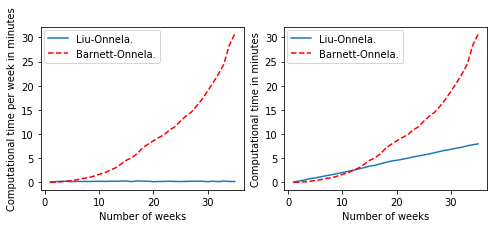

In [21]:
plt.figure(figsize=(8,3))
plt.subplot(1, 2, 1)
plt.plot(np.arange(1,36),c,label = "Liu-Onnela.")
plt.plot(np.arange(1,36),b,"r--",label = "Barnett-Onnela.")
plt.xlabel('Number of weeks')
plt.ylabel('Computational time per week in minutes')
#plt.xticks([2,4,6,8,10,12,14,16,18,20])
plt.legend(loc='upper left', borderaxespad=0.3)

plt.subplot(1, 2, 2)
plt.plot(np.arange(1,36),a,label = "Liu-Onnela.")
plt.plot(np.arange(1,36),b,"r--",label = "Barnett-Onnela.")
plt.xlabel('Number of weeks')
plt.ylabel('Computational time in minutes')
#plt.xticks([2,4,6,8,10,12,14,16,18,20])
plt.legend(loc='upper left', borderaxespad=0.3)

plt.savefig("compute_t.pdf")

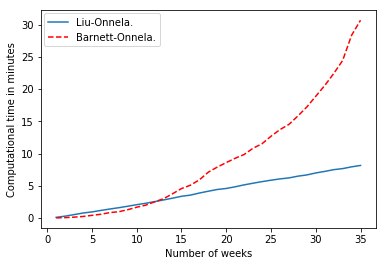

In [19]:
plt.figure(figsize=(6,4))
plt.plot(np.arange(1,36),a,label = "Liu-Onnela.")
plt.plot(np.arange(1,36),b,"r--",label = "Barnett-Onnela.")
plt.xlabel('Number of weeks')
plt.ylabel('Computational time in minutes')
#plt.xticks([2,4,6,8,10,12,14,16,18,20])
plt.legend(loc='upper left', borderaxespad=0.3)
plt.savefig("compute_t.pdf")

In [15]:
fulldata = pd.read_csv("C:/Users/glius/Google Drive/Thesis/paper 1/rawdata.csv")
fulldata.timestamp = fulldata.timestamp
fulldata.head(10)
fulldata = np.array(fulldata)

In [17]:
obsdata = pd.read_csv("C:/Users/glius/Google Drive/Thesis/paper 1/obsdata.csv")
obsdata.timestamp = obsdata.timestamp*1000
obsdata.head(10)

,timestamp,latitude,longitude,accuracy
0,1554697680000,42.366210,-71.11309,20
1,1554697681000,42.366249,-71.11311,20
2,1554697682000,42.366289,-71.11313,20
3,1554697683000,42.366328,-71.11315,20
4,1554697684000,42.366367,-71.11317,20
5,1554697685000,42.366407,-71.11319,20
6,1554697686000,42.366446,-71.11321,20
7,1554697687000,42.366485,-71.11323,20
8,1554697688000,42.366525,-71.11325,20
9,1554697689000,42.366564,-71.11327,20


In [18]:
data = obsdata
itrvl = 10
r=None; w=None; h=None
if r is None:
  r = itrvl
  #r = np.sqrt(itrvl)
if h is None:
  h = r
if w is None:
  w = np.mean(data.accuracy)

In [19]:
t_start = np.array(data.timestamp)[0]/1000
t_end = np.array(data.timestamp)[-1]/1000
avgmat = np.empty([int(np.ceil((t_end-t_start)/itrvl))+2,4])
IDam = 0
count = 0
nextline=[1,t_start+itrvl/2,data.iloc[0,1],data.iloc[0,2]]
numitrvl=1
for i in np.arange(1,data.shape[0]):
  if data.iloc[i,0]/1000 < t_start+itrvl:
    nextline[2]=nextline[2]+data.iloc[i,1]
    nextline[3]=nextline[3]+data.iloc[i,2]
    numitrvl=numitrvl+1
  else:
    nextline[2]=nextline[2]/numitrvl
    nextline[3]=nextline[3]/numitrvl
    avgmat[IDam,:]=nextline
    count=count+1
    IDam=IDam+1
    nummiss=int(np.floor((data.iloc[i,0]/1000-(t_start+itrvl))/itrvl))
    if nummiss>0:
      avgmat[IDam,:] = [4,t_start+itrvl,t_start+itrvl*(nummiss+1),None]
      count=count+1
      IDam=IDam+1
    t_start=t_start+itrvl*(nummiss+1)
    nextline[0]=1
    nextline[1]=t_start+itrvl/2
    nextline[2]=data.iloc[i,1]
    nextline[3]=data.iloc[i,2]
    numitrvl=1

avgmat = avgmat[0:count,:]
ID1 = avgmat[:,0]==1
outmat = np.zeros(7)
curind = 0
sys.stdout.write("Extract flights and pauses ..."+'\n')
for i in range(avgmat.shape[0]):
  if avgmat[i,0]==4:
    #print(curind,i)
    temp = ExtractFlights(avgmat[np.arange(curind,i),:],itrvl,r,w,h)
    outmat = np.vstack((outmat,temp))
    curind=i+1
if curind<avgmat.shape[0]:
  #print(np.arange(curind,avgmat.shape[0]))
  temp = ExtractFlights(avgmat[np.arange(curind,avgmat.shape[0]),:],itrvl,r,w,h)
  outmat = np.vstack((outmat,temp))

obs = np.delete(outmat,0,0)
MobMat = InferMobMat(obs,itrvl=10,r=None)

Extract flights and pauses ...
Infer unclassified windows ...
Merge consecutive pauses and bridge gaps ...


In [20]:
BV_set = BV_select(MobMat,sigma2,tol,d)["BV_set"]
imp_table= ImputeGPS(MobMat,BV_set,"GLC",switch)
traj = Imp2traj(imp_table,MobMat)

Imputing missing trajectories...
Tidying up the trajectories...


In [21]:
day1_obs = MobMat[MobMat[:,3]<1554697680+24*60*60,:]
day2_obs = MobMat[(MobMat[:,3]>=1554697680+24*60*60)*(MobMat[:,3]<1554697680+48*60*60),:]
day3_obs = MobMat[MobMat[:,3]>=1554697680+48*60*60,:]
day1_full = fulldata[fulldata[:,0]<1554697680+24*60*60,:]
day2_full = fulldata[(fulldata[:,0]>=1554697680+24*60*60)*(fulldata[:,0]<1554697680+48*60*60),:]
day3_full = fulldata[fulldata[:,0]>=1554697680+48*60*60,:]
day1_imp = traj[traj[:,3]<1554697680+24*60*60,:]
day2_imp = traj[(traj[:,3]>=1554697680+24*60*60)*(traj[:,3]<1554697680+48*60*60),:]
day3_imp = traj[traj[:,3]>=1554697680+48*60*60,:]

In [25]:
np.save('day1_obs.npy',day1_obs)
np.save('day1_full.npy',day1_full)
np.save('day1_imp.npy',day1_imp)
np.save('day2_obs.npy',day2_obs)
np.save('day2_full.npy',day2_full)
np.save('day2_imp.npy',day2_imp)
np.save('day3_obs.npy',day3_obs)
np.save('day3_full.npy',day3_full)
np.save('day3_imp.npy',day3_imp)

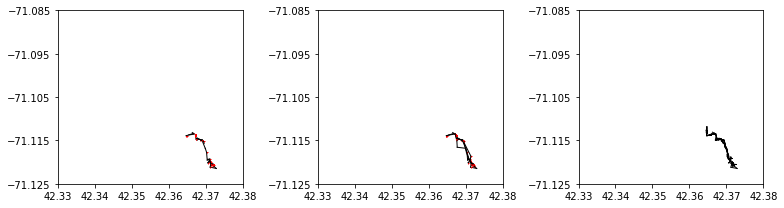

In [22]:
plt.figure(figsize=(11,3))
plt.subplot(1, 3, 1)
for i in range(np.shape(day1_obs)[0]):
  if day1_obs[i,0]==1:
    plt.plot([day1_obs[i,1],day1_obs[i,4]], [day1_obs[i,2], day1_obs[i,5]], 'k-', lw=1)
  if day1_obs[i,0]==2:
    plt.plot(day1_obs[i,1],day1_obs[i,2],"r+",ms=1) 
plt.xticks(np.arange(42.33, 42.38, step=0.01))
plt.yticks(np.arange(-71.125, -71.085, step=0.01))

plt.subplot(1, 3, 2)
for i in range(np.shape(day1_imp)[0]):
  if day1_imp[i,0]==1:
    plt.plot([day1_imp[i,1],day1_imp[i,4]], [day1_imp[i,2], day1_imp[i,5]], 'k-', lw=1)
  if day1_imp[i,0]==2:
    plt.plot(day1_imp[i,1],day1_imp[i,2],"r+",ms=1) 
plt.xticks(np.arange(42.33, 42.38, step=0.01))
plt.yticks(np.arange(-71.125, -71.085, step=0.01))
   
plt.subplot(1, 3, 3)
for i in range(np.shape(day1_full)[0]-1):
  plt.plot([day1_full[i,1],day1_full[i+1,1]], [day1_full[i,2], day1_full[i+1,2]], 'k-', lw=1)
plt.xticks(np.arange(42.33, 42.38, step=0.01))
plt.yticks(np.arange(-71.125, -71.085,step=0.01))
plt.tight_layout()

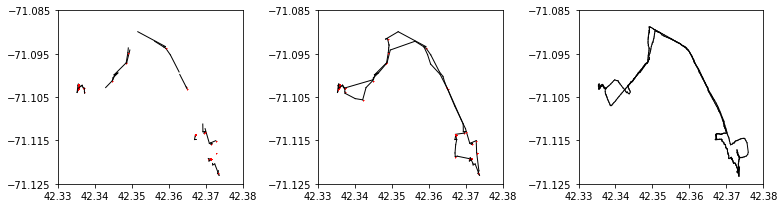

In [23]:
plt.figure(figsize=(11,3))
plt.subplot(1, 3, 1)
for i in range(np.shape(day2_obs)[0]):
  if day2_obs[i,0]==1:
    plt.plot([day2_obs[i,1],day2_obs[i,4]], [day2_obs[i,2], day2_obs[i,5]], 'k-', lw=1)
  if day2_obs[i,0]==2:
    plt.plot(day2_obs[i,1],day2_obs[i,2],"r+",ms=1) 
plt.xticks(np.arange(42.33, 42.38, step=0.01))
plt.yticks(np.arange(-71.125, -71.085, step=0.01))

plt.subplot(1, 3, 2)
for i in range(np.shape(day2_imp)[0]):
  if day2_imp[i,0]==1:
    plt.plot([day2_imp[i,1],day2_imp[i,4]], [day2_imp[i,2], day2_imp[i,5]], 'k-', lw=1)
  if day2_imp[i,0]==2:
    plt.plot(day2_imp[i,1],day2_imp[i,2],"r+",ms=1) 
plt.xticks(np.arange(42.33, 42.38, step=0.01))
plt.yticks(np.arange(-71.125, -71.085, step=0.01))

plt.subplot(1, 3, 3)
for i in range(np.shape(day2_full)[0]-1):
  plt.plot([day2_full[i,1],day2_full[i+1,1]], [day2_full[i,2], day2_full[i+1,2]], 'k-', lw=1)
plt.xticks(np.arange(42.33, 42.38, step=0.01))
plt.yticks(np.arange(-71.125, -71.085, step=0.01))
plt.tight_layout()

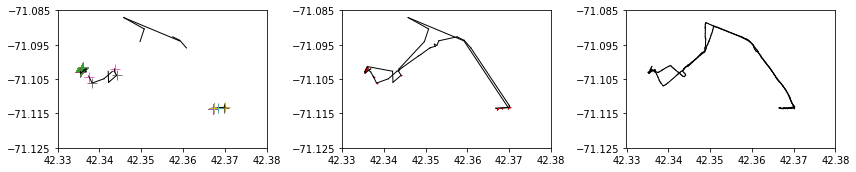

In [24]:
plt.figure(figsize=(12,2.5))
plt.subplot(1, 3, 1)
for i in range(np.shape(day3_obs)[0]):
  if day3_obs[i,0]==1:
    plt.plot([day3_obs[i,1],day3_obs[i,4]], [day3_obs[i,2], day3_obs[i,5]], 'k-', lw=1)
  if day3_obs[i,0]==2:
    plt.plot(day3_obs[i,1],day3_obs[i,2],"+",ms=10) 
plt.xticks(np.arange(42.33, 42.38, step=0.01))
plt.yticks(np.arange(-71.125, -71.085, step=0.01))

plt.subplot(1, 3, 2)
for i in range(np.shape(day3_imp)[0]):
  if day3_imp[i,0]==1:
    plt.plot([day3_imp[i,1],day3_imp[i,4]], [day3_imp[i,2], day3_imp[i,5]], 'k-', lw=1)
  if day3_imp[i,0]==2:
    plt.plot(day3_imp[i,1],day3_imp[i,2],"r+",ms=1) 
plt.xticks(np.arange(42.33, 42.38, step=0.01))
plt.yticks(np.arange(-71.125, -71.085, step=0.01))

plt.subplot(1, 3, 3)
for i in range(np.shape(day3_full)[0]-1):
  plt.plot([day3_full[i,1],day3_full[i+1,1]], [day3_full[i,2], day3_full[i+1,2]], 'k-', lw=1)
plt.xticks(np.arange(42.33, 42.38, step=0.01))
plt.yticks(np.arange(-71.125, -71.085, step=0.01))
plt.tight_layout()  

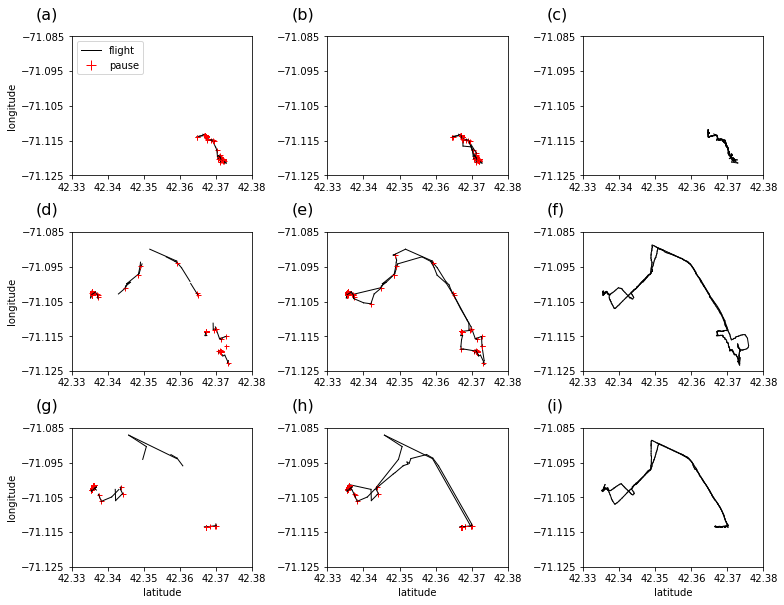

In [30]:
plt.figure(figsize=(11,8.5))
plt.subplot(3, 3, 1)
for i in range(np.shape(day1_obs)[0]):
  if day1_obs[i,0]==1:
    plt.plot([day1_obs[i,1],day1_obs[i,4]], [day1_obs[i,2], day1_obs[i,5]], 'k-', lw=1)
  if day1_obs[i,0]==2:
    plt.plot(day1_obs[i,1],day1_obs[i,2],"r+",ms=5) 
plt.xticks(np.arange(42.33, 42.38, step=0.01))
plt.yticks(np.arange(-71.125, -71.085, step=0.01))
plt.text(42.32,-71.08,'(a)',fontsize = 16)
plt.ylabel('longitude')
custom_lines = [Line2D([], [], color="black", lw=1,label = "flight"),
                Line2D([], [], color="r", linestyle = "None", marker = "+",markersize = 10, label="pause")]
plt.legend(handles=custom_lines, loc = "upper left")

plt.subplot(3, 3, 2)
for i in range(np.shape(day1_imp)[0]):
  if day1_imp[i,0]==1:
    plt.plot([day1_imp[i,1],day1_imp[i,4]], [day1_imp[i,2], day1_imp[i,5]], 'k-', lw=1)
  if day1_imp[i,0]==2:
    plt.plot(day1_imp[i,1],day1_imp[i,2],"r+",ms=5) 
plt.xticks(np.arange(42.33, 42.38, step=0.01))
plt.yticks(np.arange(-71.125, -71.085, step=0.01))
plt.text(42.32,-71.08,'(b)',fontsize = 16)
  
plt.subplot(3, 3, 3)
for i in range(np.shape(day1_full)[0]-1):
  plt.plot([day1_full[i,1],day1_full[i+1,1]], [day1_full[i,2], day1_full[i+1,2]], 'k-', lw=1)
plt.xticks(np.arange(42.33, 42.38, step=0.01))
plt.yticks(np.arange(-71.125, -71.085,step=0.01))
plt.text(42.32,-71.08,'(c)',fontsize = 16)

plt.subplot(3, 3, 4)
for i in range(np.shape(day2_obs)[0]):
  if day2_obs[i,0]==1:
    plt.plot([day2_obs[i,1],day2_obs[i,4]], [day2_obs[i,2], day2_obs[i,5]], 'k-', lw=1)
  if day2_obs[i,0]==2:
    plt.plot(day2_obs[i,1],day2_obs[i,2],"r+",ms=5) 
plt.xticks(np.arange(42.33, 42.38, step=0.01))
plt.yticks(np.arange(-71.125, -71.085, step=0.01))
plt.ylabel('longitude')
plt.text(42.32,-71.08,'(d)',fontsize = 16)

plt.subplot(3, 3, 5)
for i in range(np.shape(day2_imp)[0]):
  if day2_imp[i,0]==1:
    plt.plot([day2_imp[i,1],day2_imp[i,4]], [day2_imp[i,2], day2_imp[i,5]], 'k-', lw=1)
  if day2_imp[i,0]==2:
    plt.plot(day2_imp[i,1],day2_imp[i,2],"r+",ms=5) 
plt.xticks(np.arange(42.33, 42.38, step=0.01))
plt.yticks(np.arange(-71.125, -71.085, step=0.01))
plt.text(42.32,-71.08,'(e)',fontsize = 16)

plt.subplot(3, 3, 6)
for i in range(np.shape(day2_full)[0]-1):
  plt.plot([day2_full[i,1],day2_full[i+1,1]], [day2_full[i,2], day2_full[i+1,2]], 'k-', lw=1)
plt.xticks(np.arange(42.33, 42.38, step=0.01))
plt.yticks(np.arange(-71.125, -71.085, step=0.01))
plt.text(42.32,-71.08,'(f)',fontsize = 16)

plt.subplot(3, 3, 7)
for i in range(np.shape(day3_obs)[0]):
  if day3_obs[i,0]==1:
    plt.plot([day3_obs[i,1],day3_obs[i,4]], [day3_obs[i,2], day3_obs[i,5]], 'k-', lw=1)
  if day3_obs[i,0]==2:
    plt.plot(day3_obs[i,1],day3_obs[i,2],"r+",ms=5) 
plt.xticks(np.arange(42.33, 42.38, step=0.01))
plt.yticks(np.arange(-71.125, -71.085, step=0.01))
plt.xlabel('latitude')
plt.ylabel('longitude')
plt.text(42.32,-71.08,'(g)',fontsize = 16)

plt.subplot(3, 3, 8)
for i in range(np.shape(day3_imp)[0]):
  if day3_imp[i,0]==1:
    plt.plot([day3_imp[i,1],day3_imp[i,4]], [day3_imp[i,2], day3_imp[i,5]], 'k-', lw=1)
  if day3_imp[i,0]==2:
    plt.plot(day3_imp[i,1],day3_imp[i,2],"r+",ms=5) 
plt.xticks(np.arange(42.33, 42.38, step=0.01))
plt.yticks(np.arange(-71.125, -71.085, step=0.01))
plt.xlabel('latitude')
plt.text(42.32,-71.08,'(h)',fontsize = 16)

plt.subplot(3, 3, 9)
for i in range(np.shape(day3_full)[0]-1):
  plt.plot([day3_full[i,1],day3_full[i+1,1]], [day3_full[i,2], day3_full[i+1,2]], 'k-', lw=1)
plt.xticks(np.arange(42.33, 42.38, step=0.01))
plt.yticks(np.arange(-71.125, -71.085, step=0.01))
plt.xlabel('latitude')
plt.text(42.32,-71.08,'(i)',fontsize = 16)
plt.tight_layout() 
plt.savefig("real_traj.pdf")

In [21]:
day1_full = np.array(pd.read_csv("day1_full.csv"))
day1_full[:,1] = day1_full[:,1]/11119.5*0.1+42
day1_full[:,2] = day1_full[:,2]/8263.3*0.1-71
day1_full0 = day1_full[np.arange(0,86400,step=20),:]
day1_full[:,0] = day1_full[:,0] +  1554697680

day2_full = np.array(pd.read_csv("day2_full.csv"))
day2_full[:,1] = day2_full[:,1]/11119.5*0.1+42
day2_full[:,2] = day2_full[:,2]/8263.3*0.1-71
day2_full0 = day2_full[np.arange(0,86400,step=20),:]
day2_full[:,0] = day2_full[:,0] +  1554697680 + 86400

day3_full = np.array(pd.read_csv("day3_full.csv"))
day3_full[:,1] = day3_full[:,1]/11119.5*0.1+42
day3_full[:,2] = day3_full[:,2]/8263.3*0.1-71
day3_full0 = day3_full[np.arange(0,86400,step=20),:]
day3_full[:,0] = day3_full[:,0] +  1554697680 + 86400*2

In [32]:
all_data = np.vstack((day1_full,day2_full,day3_full))
data = all_data[:100,:]
for i in np.arange(np.random.randint(200,1800,1)[0],all_data.shape[0],90*60):
  data = np.vstack((data,all_data[np.arange(i,i+120),:]))
data[:,0] = data[:,0]*1000
data[1:,0] - data[:-1,0] 

array([1000., 1000., 1000., ..., 1000., 1000., 1000.])

In [33]:
data = pd.DataFrame(data, columns=['timestamp','latitude','longitude','accuracy'])
itrvl = 10
r=None; w=None; h=None
if r is None:
  r = itrvl
  #r = np.sqrt(itrvl)
if h is None:
  h = r
if w is None:
  w = np.mean(data.accuracy)

In [34]:
t_start = np.array(data.timestamp)[0]/1000
t_end = np.array(data.timestamp)[-1]/1000
avgmat = np.empty([int(np.ceil((t_end-t_start)/itrvl))+2,4])
IDam = 0
count = 0
nextline=[1,t_start+itrvl/2,data.iloc[0,1],data.iloc[0,2]]
numitrvl=1
for i in np.arange(1,data.shape[0]):
  if data.iloc[i,0]/1000 < t_start+itrvl:
    nextline[2]=nextline[2]+data.iloc[i,1]
    nextline[3]=nextline[3]+data.iloc[i,2]
    numitrvl=numitrvl+1
  else:
    nextline[2]=nextline[2]/numitrvl
    nextline[3]=nextline[3]/numitrvl
    avgmat[IDam,:]=nextline
    count=count+1
    IDam=IDam+1
    nummiss=int(np.floor((data.iloc[i,0]/1000-(t_start+itrvl))/itrvl))
    if nummiss>0:
      avgmat[IDam,:] = [4,t_start+itrvl,t_start+itrvl*(nummiss+1),None]
      count=count+1
      IDam=IDam+1
    t_start=t_start+itrvl*(nummiss+1)
    nextline[0]=1
    nextline[1]=t_start+itrvl/2
    nextline[2]=data.iloc[i,1]
    nextline[3]=data.iloc[i,2]
    numitrvl=1

avgmat = avgmat[0:count,:]
ID1 = avgmat[:,0]==1
outmat = np.zeros(7)
curind = 0
sys.stdout.write("Extract flights and pauses ..."+'\n')
for i in range(avgmat.shape[0]):
  if avgmat[i,0]==4:
    #print(curind,i)
    temp = ExtractFlights(avgmat[np.arange(curind,i),:],itrvl,r,w,h)
    outmat = np.vstack((outmat,temp))
    curind=i+1
if curind<avgmat.shape[0]:
  #print(np.arange(curind,avgmat.shape[0]))
  temp = ExtractFlights(avgmat[np.arange(curind,avgmat.shape[0]),:],itrvl,r,w,h)
  outmat = np.vstack((outmat,temp))

obs = np.delete(outmat,0,0)
MobMat = InferMobMat(obs,itrvl=10,r=None)

Extract flights and pauses ...
Infer unclassified windows ...
Merge consecutive pauses and bridge gaps ...


Imputing missing trajectories...
Tidying up the trajectories...


([<matplotlib.axis.YTick at 0x177da69c4e0>,
 <a list of 8 Text yticklabel objects>)

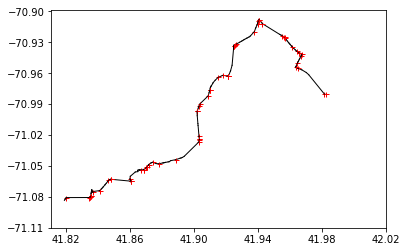

In [35]:
BV_set = BV_select(MobMat,sigma2,tol,d)["BV_set"]
imp_table= ImputeGPS(MobMat,MobMat,"GLC",2)
traj = Imp2traj(imp_table,MobMat)
day1_imp = traj[traj[:,6]<1554697680+86400-600,:]
day2_imp = traj[(traj[:,3]>=1554697680+86400)*(traj[:,6]<1554697680+86400*2-600),:]
day3_imp = traj[traj[:,3]>=1554697680+86400*2,:]
for i in np.arange(10,np.shape(day1_imp)[0]-10):
  if day1_imp[i,0]==1:
    plt.plot([day1_imp[i,1],day1_imp[i,4]], [day1_imp[i,2], day1_imp[i,5]], 'k-', lw=1)
  if day1_imp[i,0]==2:
    plt.plot(day1_imp[i,1],day1_imp[i,2],"r+",ms=5) 
plt.xticks(np.arange(41.82, 42.03, step=0.04))
plt.yticks(np.arange(-71.11, -70.89, step=0.03))

Text(0.5, 1.0, 'Day 2, imputed')

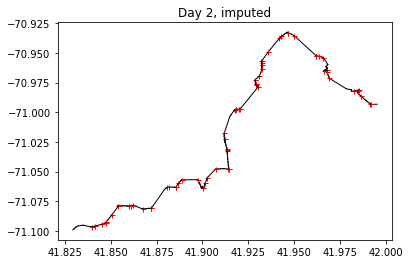

In [36]:
for i in np.arange(10,np.shape(day2_imp)[0]-10):
  if day2_imp[i,0]==1:
    plt.plot([day2_imp[i,1],day2_imp[i,4]], [day2_imp[i,2], day2_imp[i,5]], 'k-', lw=1)
  if day2_imp[i,0]==2:
    plt.plot(day2_imp[i,1],day2_imp[i,2],"r+",ms=5) 
plt.title("Day 2, imputed")

Text(0.5, 1.0, 'Day 3, imputed')

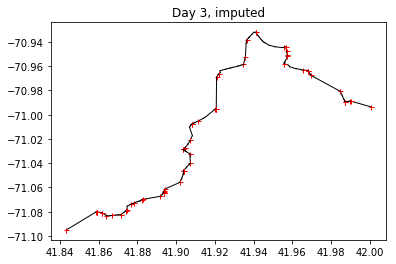

In [37]:
for i in np.arange(10,np.shape(day3_imp)[0]-10):
  if day3_imp[i,0]==1:
    plt.plot([day3_imp[i,1],day3_imp[i,4]], [day3_imp[i,2], day3_imp[i,5]], 'k-', lw=1)
  if day3_imp[i,0]==2:
    plt.plot(day3_imp[i,1],day3_imp[i,2],"r+",ms=5) 
plt.title("Day 3, imputed")

In [38]:
obsdata = pd.read_csv("C:/Users/glius/Google Drive/Thesis/paper 1/vonmises_obs.csv")
obsdata.timestamp = obsdata.timestamp*1000 + 1554697680000
data = obsdata
itrvl = 10
r=None; w=None; h=None
if r is None:
  r = itrvl
  #r = np.sqrt(itrvl)
if h is None:
  h = r
if w is None:
  w = np.mean(data.accuracy)
t_start = np.array(data.timestamp)[0]/1000
t_end = np.array(data.timestamp)[-1]/1000
avgmat = np.empty([int(np.ceil((t_end-t_start)/itrvl))+2,4])
IDam = 0
count = 0
nextline=[1,t_start+itrvl/2,data.iloc[0,1],data.iloc[0,2]]
numitrvl=1
for i in np.arange(1,data.shape[0]):
  if data.iloc[i,0]/1000 < t_start+itrvl:
    nextline[2]=nextline[2]+data.iloc[i,1]
    nextline[3]=nextline[3]+data.iloc[i,2]
    numitrvl=numitrvl+1
  else:
    nextline[2]=nextline[2]/numitrvl
    nextline[3]=nextline[3]/numitrvl
    avgmat[IDam,:]=nextline
    count=count+1
    IDam=IDam+1
    nummiss=int(np.floor((data.iloc[i,0]/1000-(t_start+itrvl))/itrvl))
    if nummiss>0:
      avgmat[IDam,:] = [4,t_start+itrvl,t_start+itrvl*(nummiss+1),None]
      count=count+1
      IDam=IDam+1
    t_start=t_start+itrvl*(nummiss+1)
    nextline[0]=1
    nextline[1]=t_start+itrvl/2
    nextline[2]=data.iloc[i,1]
    nextline[3]=data.iloc[i,2]
    numitrvl=1

avgmat = avgmat[0:count,:]
ID1 = avgmat[:,0]==1
outmat = np.zeros(7)
curind = 0
sys.stdout.write("Extract flights and pauses ..."+'\n')
for i in range(avgmat.shape[0]):
  if avgmat[i,0]==4:
    #print(curind,i)
    temp = ExtractFlights(avgmat[np.arange(curind,i),:],itrvl,r,w,h)
    outmat = np.vstack((outmat,temp))
    curind=i+1
if curind<avgmat.shape[0]:
  #print(np.arange(curind,avgmat.shape[0]))
  temp = ExtractFlights(avgmat[np.arange(curind,avgmat.shape[0]),:],itrvl,r,w,h)
  outmat = np.vstack((outmat,temp))

obs = np.delete(outmat,0,0)
MobMat = InferMobMat(obs,itrvl=10,r=None)
day1_obs = MobMat[MobMat[:,3]<1554697680+86400,:]
day2_obs = MobMat[(MobMat[:,3]>=1554697680+86400)*(MobMat[:,6]<1554697680+86400*2),:]
day3_obs = MobMat[MobMat[:,3]>=1554697680+86400*2,:]

Extract flights and pauses ...
Infer unclassified windows ...
Merge consecutive pauses and bridge gaps ...


In [39]:
np.save('day1_obs_vonmise.npy',day1_obs)
np.save('day1_full_vonmise.npy',day1_full0)
np.save('day1_imp_vonmise.npy',day1_imp)
np.save('day2_obs_vonmise.npy',day2_obs)
np.save('day2_full_vonmise.npy',day2_full0)
np.save('day2_imp_vonmise.npy',day2_imp)
np.save('day3_obs_vonmise.npy',day3_obs)
np.save('day3_full_vonmise.npy',day3_full0)
np.save('day3_imp_vonmise.npy',day3_imp)

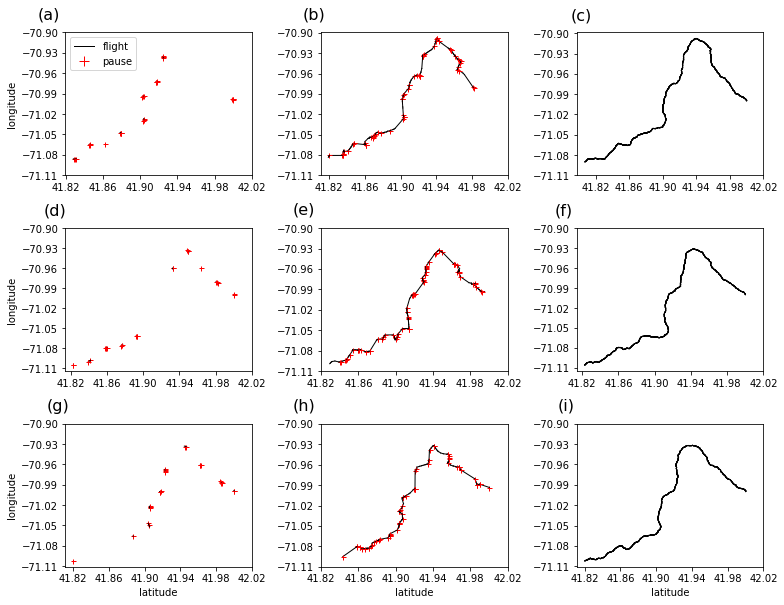

In [40]:
plt.figure(figsize=(11,8.5))
plt.subplot(3, 3, 1)
for i in range(np.shape(day1_obs)[0]):
  if day1_obs[i,0]==1:
    plt.plot([day1_obs[i,1],day1_obs[i,4]], [day1_obs[i,2], day1_obs[i,5]], 'k-', lw=1)
  if day1_obs[i,0]==2:
    plt.plot(day1_obs[i,1],day1_obs[i,2],"r+",ms=5) 
plt.text(41.79,-70.88,'(a)',fontsize = 16)
plt.ylabel('longitude')
plt.xticks(np.arange(41.82, 42.03, step=0.04))
plt.yticks(np.arange(-71.11, -70.89, step=0.03))
custom_lines = [Line2D([], [], color="black", lw=1,label = "flight"),
                Line2D([], [], color="r", linestyle = "None", marker = "+",markersize = 10, label="pause")]
plt.legend(handles=custom_lines, loc = "upper left")

plt.subplot(3, 3, 2)
for i in np.arange(10,np.shape(day1_imp)[0]-10):
  if day1_imp[i,0]==1:
    plt.plot([day1_imp[i,1],day1_imp[i,4]], [day1_imp[i,2], day1_imp[i,5]], 'k-', lw=1)
  if day1_imp[i,0]==2:
    plt.plot(day1_imp[i,1],day1_imp[i,2],"r+",ms=5) 
plt.text(41.79,-70.88,'(b)',fontsize = 16)
plt.xticks(np.arange(41.82, 42.03, step=0.04))
plt.yticks(np.arange(-71.11, -70.89, step=0.03))
  
plt.subplot(3, 3, 3)
for i in range(np.shape(day1_full0)[0]-1):
  plt.plot([day1_full0[i,1],day1_full0[i+1,1]], [day1_full0[i,2], day1_full0[i+1,2]], 'k-', lw=1)
plt.text(41.79,-70.88,'(c)',fontsize = 16)
plt.xticks(np.arange(41.82, 42.03, step=0.04))
plt.yticks(np.arange(-71.11, -70.89, step=0.03))

plt.subplot(3, 3, 4)
for i in range(np.shape(day2_obs)[0]):
  if day2_obs[i,0]==1:
    plt.plot([day2_obs[i,1],day2_obs[i,4]], [day2_obs[i,2], day2_obs[i,5]], 'k-', lw=1)
  if day2_obs[i,0]==2:
    plt.plot(day2_obs[i,1],day2_obs[i,2],"r+",ms=5) 
plt.ylabel('longitude')
plt.text(41.79,-70.88,'(d)',fontsize = 16)
plt.xticks(np.arange(41.82, 42.03, step=0.04))
plt.yticks(np.arange(-71.11, -70.89, step=0.03))

plt.subplot(3, 3, 5)
for i in np.arange(10,np.shape(day2_imp)[0]-10):
  if day2_imp[i,0]==1:
    plt.plot([day2_imp[i,1],day2_imp[i,4]], [day2_imp[i,2], day2_imp[i,5]], 'k-', lw=1)
  if day2_imp[i,0]==2:
    plt.plot(day2_imp[i,1],day2_imp[i,2],"r+",ms=5) 
plt.text(41.79,-70.88,'(e)',fontsize = 16)
plt.xticks(np.arange(41.82, 42.03, step=0.04))
plt.yticks(np.arange(-71.11, -70.89, step=0.03))

plt.subplot(3, 3, 6)
for i in range(np.shape(day2_full0)[0]-1):
  plt.plot([day2_full0[i,1],day2_full0[i+1,1]], [day2_full0[i,2], day2_full0[i+1,2]], 'k-', lw=1)
plt.text(41.79,-70.88,'(f)',fontsize = 16)
plt.xticks(np.arange(41.82, 42.03, step=0.04))
plt.yticks(np.arange(-71.11, -70.89, step=0.03))

plt.subplot(3, 3, 7)
for i in range(np.shape(day3_obs)[0]):
  if day3_obs[i,0]==1:
    plt.plot([day3_obs[i,1],day3_obs[i,4]], [day3_obs[i,2], day3_obs[i,5]], 'k-', lw=1)
  if day3_obs[i,0]==2:
    plt.plot(day3_obs[i,1],day3_obs[i,2],"r+",ms=5) 
plt.xlabel('latitude')
plt.ylabel('longitude')
plt.text(41.79,-70.88,'(g)',fontsize = 16)
plt.xticks(np.arange(41.82, 42.03, step=0.04))
plt.yticks(np.arange(-71.11, -70.89, step=0.03))

plt.subplot(3, 3, 8)
for i in np.arange(10,np.shape(day3_imp)[0]-10):
  if day3_imp[i,0]==1:
    plt.plot([day3_imp[i,1],day3_imp[i,4]], [day3_imp[i,2], day3_imp[i,5]], 'k-', lw=1)
  if day3_imp[i,0]==2:
    plt.plot(day3_imp[i,1],day3_imp[i,2],"r+",ms=5) 
plt.xlabel('latitude')
plt.text(41.79,-70.88,'(h)',fontsize = 16)
plt.xticks(np.arange(41.82, 42.03, step=0.04))
plt.yticks(np.arange(-71.11, -70.89, step=0.03))

plt.subplot(3, 3, 9)
for i in range(np.shape(day3_full0)[0]-1):
  plt.plot([day3_full0[i,1],day3_full0[i+1,1]], [day3_full0[i,2], day3_full0[i+1,2]], 'k-', lw=1)
plt.xlabel('latitude')
plt.text(41.79,-70.88,'(i)',fontsize = 16)
plt.xticks(np.arange(41.82, 42.03, step=0.04))
plt.yticks(np.arange(-71.11, -70.89, step=0.03))
plt.tight_layout() 
plt.savefig("sim_traj.pdf")